In [1]:
%cd ../code/

/opt/ml/team/gj/code


In [2]:
import os
import argparse
import multiprocessing
import numpy as np
import random
import time
import shutil
import torch
import torch.nn as nn
from torchvision import transforms
import yaml
from tqdm import tqdm
from checkpoint import (
    default_checkpoint,
    load_checkpoint,
    save_checkpoint,
    init_logging,
    log_stuff,
    log_best_stuff,
)
from psutil import virtual_memory

from flags import Flags
from utils import (
    get_network,
    get_enc_dec_optimizer,
    setup_enc_dec_optimizer,
    get_enc_dec_lr_scheduler,
)
from dataset import dataset_loader, START, PAD,load_vocab

from metrics import word_error_rate,sentence_acc

from torch.cuda.amp import (
    GradScaler, 
    autocast,
)

from train import run_epoch

import torch
import os
from train import id_to_string
from metrics import word_error_rate, sentence_acc
from checkpoint import load_checkpoint
from torchvision import transforms
from dataset import LoadEvalDataset, collate_eval_batch, START, PAD, SizeBatchSampler
from flags import Flags
from utils import get_network, get_optimizer
import csv
from torch.utils.data import DataLoader
import argparse
import random
from tqdm import tqdm


ImportError: cannot import name 'run_epoch' from 'train' (/opt/ml/team/gj/code/train.py)

In [ ]:
checkpoint = "/opt/ml/team/gj/code/log/satrn_locality_aware/checkpoints/best.pth"

In [ ]:
is_cuda = not torch.cuda.is_available()
checkpoint = load_checkpoint(checkpoint, cuda=is_cuda)
options, _ = Flags(checkpoint["configs"]).get()
torch.manual_seed(options.seed)
random.seed(options.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
hardware = "cuda" if is_cuda else "cpu"
device = torch.device(hardware)
print("--------------------------------")
print("Running {} on device {}\n".format(options.network, device))

model_checkpoint = checkpoint["model"]
if model_checkpoint:
    print(
        "[+] Checkpoint\n",
        "Resuming from epoch : {}\n".format(checkpoint["epoch"]),
    )


if options.data.flexible_image_size:
    transformed = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
else:
    transformed = transforms.Compose(
        [
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ]
    )


In [ ]:
if options.data.flexible_image_size:
    transformed = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
else:
    transformed = transforms.Compose(
        [
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ]
    )

train_data_loader, validation_data_loader, train_dataset, valid_dataset = dataset_loader(options, transformed)

In [3]:
model = get_network(
    options.network,
    options,
    model_checkpoint,
    device,
    valid_dataset,
)
model.eval()
print()

NameError: name 'options' is not defined

In [8]:
# criterion = model.criterion.to(device)

In [9]:
# validation_result = run_epoch(
#     validation_data_loader,
#     model,
#     'epoch_text',
#     criterion,
#     None,
#     None,
#     None,
#     None,
#     None,
#     None,
#     device,
#     options=options,
#     use_amp=options.use_amp and device.type == 'cuda',
#     train=False,
# )

In [6]:
train = False
data_loader = validation_data_loader
use_amp=options.use_amp and device.type == 'cuda'
epoch_text = ''
teacher_forcing_ratio = 0
    
# Disables autograd during validation mode
torch.set_grad_enabled(False)

model.eval()
bad_ones = []
if options.SATRN.solve_extra_pb:
    losses_satrn = []
    losses_level = []
    losses_source = []
losses = []
total_inputs = 0
correct_symbols = 0
total_symbols = 0
wer=0
num_wer=0
sent_acc=0
num_sent_acc=0

idx = 0
with tqdm(
    desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
    total=len(data_loader.dataset),
    dynamic_ncols=True,
    leave=False,
) as pbar:
    for d in data_loader:
        input = d["image"].to(device)

        # The last batch may not be a full batch
        curr_batch_size = len(input)
        expected = d["truth"]["encoded"].to(device)
        levels_expected = d['level'].to(device)
        sources_expected = d['source'].to(device)

        # Replace -1 with the PAD token
        expected[expected == -1] = data_loader.dataset.token_to_id[PAD]

        with autocast(enabled=use_amp):
            if options.SATRN.solve_extra_pb:
                output, level_result, source_result = \
                    model(input, expected, train, teacher_forcing_ratio)
                decoded_values = output.transpose(1, 2)
                _, sequence = torch.topk(decoded_values, 1, dim=1)
                sequence = sequence.squeeze(1)
                loss_satrn = criterion[0](decoded_values, expected[:, 1:])
                loss_level = criterion[1](level_result, levels_expected)
                loss_source = criterion[2](source_result, sources_expected)
                loss = loss_satrn + loss_level + loss_source
            else:
                output = model(input, expected, train, teacher_forcing_ratio)
                decoded_values = output.transpose(1, 2)
                _, sequence = torch.topk(decoded_values, 1, dim=1)
                sequence = sequence.squeeze(1)
                loss = criterion(decoded_values, expected[:, 1:])

        
        if options.SATRN.solve_extra_pb:
            losses.append(loss.item() * len(input))
            losses_satrn.append(loss_satrn.item() * len(input))
            losses_level.append(loss_level.item() * len(input))
            losses_source.append(loss_source.item() * len(input))
        else:
            losses.append(loss.item() * len(input))
        total_inputs += len(input)

        expected[expected == data_loader.dataset.token_to_id[PAD]] = -1
        expected_str = id_to_string(expected, data_loader,do_eval=1)
        sequence_str = id_to_string(sequence, data_loader,do_eval=1)
        wer += word_error_rate(sequence_str,expected_str)
        num_wer += len(expected_str)
        sent_acc += sentence_acc(sequence_str,expected_str)
        num_sent_acc += len(expected_str)
        correct_symbols += torch.sum(sequence == expected[:, 1:], dim=(0, 1)).item()
        total_symbols += torch.sum(expected[:, 1:] != -1, dim=(0, 1)).item()
        
        for path, estr, sstr in zip(d['path'], expected_str, sequence_str):
            if estr != sstr:
                bad_ones.append({
                    'idx': idx,
                    'path':path,
                    'expected':estr,
                    'sequence':sstr,
                })
            idx += 1

        pbar.update(curr_batch_size)

expected = id_to_string(expected, data_loader)
sequence = id_to_string(sequence, data_loader)

if options.SATRN.solve_extra_pb:
    result = {
        "loss": np.sum(losses_satrn) / total_inputs,
        'loss_total': np.sum(losses) / total_inputs,
        'loss_level': np.sum(losses_level) / total_inputs,
        'loss_source': np.sum(losses_source) / total_inputs,
        "correct_symbols": correct_symbols,
        "total_symbols": total_symbols,
        "wer": wer,
        "num_wer":num_wer,
        "sent_acc": sent_acc,
        "num_sent_acc":num_sent_acc
    }
else:
    result = {
        "loss": np.sum(losses) / total_inputs,
        "correct_symbols": correct_symbols,
        "total_symbols": total_symbols,
        "wer": wer,
        "num_wer":num_wer,
        "sent_acc": sent_acc,
        "num_sent_acc":num_sent_acc
    }

NameError: name 'validation_data_loader' is not defined

In [47]:
result

{'loss': 0.0,
 'correct_symbols': 14,
 'total_symbols': 101,
 'wer': 0.6078431372549019,
 'num_wer': 1,
 'sent_acc': 0,
 'num_sent_acc': 1}

In [48]:
!ls /opt/ml/team/gj/notebooks

fix_wrong_checkpoint.ipynb  real_eda.ipynb		 val_output.pck
pretrain_hugway.ipynb	    see_wrong.ipynb		 wandb
pretrained_model.ipynb	    split_by_source_level.ipynb


In [28]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import math
import pickle
plt.style.use('dark_background')

In [7]:
# pickle.dump(bad_ones, open('/opt/ml/team/gj/notebooks/val_output.pck', 'wb'))

In [8]:
loaded = pickle.load(open('/opt/ml/team/gj/notebooks/val_output.pck', 'rb'))
bad_ones = loaded

In [78]:
idx -= 2

In [52]:
idx = 0

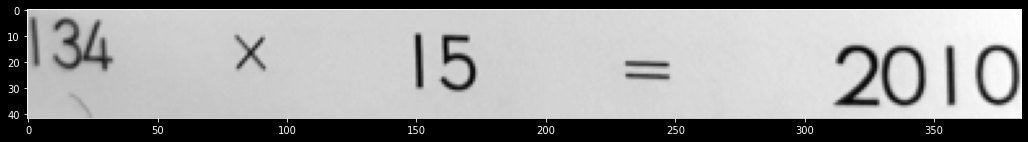

grnd 1 3 4 \times 1 5 = 2 0 1 0 


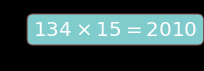

pred 1 3 4 \times 1 5 = 2 0 


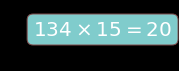

In [130]:
path = bad_ones[idx]['path']
pred = bad_ones[idx]['sequence']
gt = bad_ones[idx]['expected']

image = Image.open(path)
image = image.convert("L")

bounding_box = ImageOps.invert(image).getbbox()
image = image.crop(bounding_box)
rw, rh = image.size

T = 128*128
div = rw * rh / T
w = round(rw/math.sqrt(div))
h = round(rh/math.sqrt(div))
w = round(w / 32) * 32
h = T // w
transformed = transforms.Compose(
    [
        transforms.Resize((h, w))
    ]
)

plt.figure(figsize = (20,2))
tr_image = transformed(image)
plt.imshow(tr_image, cmap='gray')
plt.show()

print('grnd', gt)
box1 = {'boxstyle': 'round',
    'ec': (0.5, 0.3, 0.3), # edgecolor
    'fc': (0.5, 0.8, 0.8)} # facecolor
    
ax = plt.axes([0,0,0.2,0.2]) #left,bottom,width,height
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.text(0.3,0.5,'$%s$' %gt,size=20, bbox=box1)
plt.show()


print('pred', pred)
box1 = {'boxstyle': 'round',
    'ec': (0.5, 0.3, 0.3), # edgecolor
    'fc': (0.5, 0.8, 0.8)} # facecolor
    

ax = plt.axes([0,0,0.2,0.2]) #left,bottom,width,height
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.text(0.3,0.5,'$%s$' %
         pred,size=20, bbox=box1)
plt.show()


idx += 1

In [270]:
pred

'P - 3 Q Q = \\left( 5 x ^ { 2 } y + 2 y + 2 y ^ { 2 } + + + 2 x ^ 3 3 3 3 - 3 - ^ ^ ^ { 2 } - ^ ^ { 2 } } } \\right) 2 } '

In [16]:
bad_ones[idx]

{'idx': 5,
 'path': '/opt/ml/input/data/train_dataset/images/train_01619.jpg',
 'expected': '- 6 x - 8 ',
 'sequence': '- 6 x - '}

In [9]:
from dataset import LoadDataset, load_levels, load_sources, split_gt, collate_batch

In [10]:
if options.data.flexible_image_size:
    transformed = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
else:
    transformed = transforms.Compose(
        [
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ]
    )

levels = load_levels(options.data.level_paths)
sources = load_sources(options.data.source_paths)
# train_data_loader, validation_data_loader, train_dataset, valid_dataset = dataset_loader(options, transformed)

In [11]:
val_data = []
for path in options.data.test:
    val_data.extend(split_gt(path, 1.0))

In [12]:
path

'/opt/ml/input/data/train_dataset/test_gt_s:1_l:4.txt'

In [13]:
val_data[0]

['/opt/ml/input/data/train_dataset/images/train_53186.jpg',
 '2 \\frac { 2 } { 3 } + 3 \\frac { 5 } { 8 } =']

In [14]:
filter_by_latex = r'1 3 4 \times 1 5 = 2 0 1 0'
filtered_data = []
for p, gt in val_data:
    if gt == filter_by_latex:
        filtered_data.append((p, gt))

In [15]:
filtered_data

[('/opt/ml/input/data/train_dataset/images/train_06512.jpg',
  '1 3 4 \\times 1 5 = 2 0 1 0')]

In [16]:
 train_dataset = LoadDataset(
    filtered_data, options.data.token_paths, sources=sources,
    levels=levels, crop=options.data.crop,
    transform=transformed, rgb=options.data.rgb,
    max_resolution=options.input_size.height * options.input_size.width,
    is_flexible=options.data.flexible_image_size,
)

In [17]:
model = get_network(
    options.network,
    options,
    model_checkpoint,
    device,
    train_dataset,
)
model.eval()
print()

In [18]:
if options.data.flexible_image_size:
    train_sampler = SizeBatchSampler(train_dataset, options.batch_size, is_random=False)
    train_data_loader = DataLoader(
        train_dataset,
        batch_sampler=train_sampler,
        num_workers=1,
        collate_fn=collate_batch,
    )
else:
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=options.batch_size,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_batch,
    )

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
train_dataset[0]

{'path': '/opt/ml/input/data/train_dataset/images/train_06512.jpg',
 'truth': {'text': '1 3 4 \\times 1 5 = 2 0 1 0',
  'encoded': [0, 125, 111, 85, 199, 125, 70, 180, 177, 14, 125, 14, 1]},
 'image': tensor([[[0.5532, 0.5544, 0.5520,  ..., 0.7215, 0.7065, 0.7152],
          [0.5389, 0.5496, 0.5584,  ..., 0.7113, 0.7082, 0.7057],
          [0.5405, 0.5467, 0.5370,  ..., 0.7166, 0.7171, 0.7132],
          ...,
          [0.5596, 0.5698, 0.5484,  ..., 0.6895, 0.6966, 0.6943],
          [0.5568, 0.5610, 0.5490,  ..., 0.6973, 0.6989, 0.7052],
          [0.5657, 0.5667, 0.5611,  ..., 0.6997, 0.6989, 0.6960]]]),
 'source': 0,
 'level': 0}

In [29]:
train = False
data_loader = train_data_loader
use_amp=options.use_amp and device.type == 'cuda'
epoch_text = ''
teacher_forcing_ratio = 0
    
# Disables autograd during validation mode
torch.set_grad_enabled(False)

model.eval()
if options.SATRN.solve_extra_pb:
    losses_satrn = []
    losses_level = []
    losses_source = []
losses = []
total_inputs = 0
correct_symbols = 0
total_symbols = 0
wer=0
num_wer=0
sent_acc=0
num_sent_acc=0

idx = 0
with tqdm(
    desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
    total=len(data_loader.dataset),
    dynamic_ncols=True,
    leave=False,
) as pbar:
    for d in data_loader:
        input = d["image"].to(device)

        # The last batch may not be a full batch
        curr_batch_size = len(input)
        expected = d["truth"]["encoded"].to(device)
        levels_expected = d['level'].to(device)
        sources_expected = d['source'].to(device)

        # Replace -1 with the PAD token
        expected[expected == -1] = data_loader.dataset.token_to_id[PAD]

        with autocast(enabled=use_amp):
            output, attns_1, attns_2 = model(input, expected, train, teacher_forcing_ratio, return_attn=True)
            decoded_values = output.transpose(1, 2)
            _, sequence = torch.topk(decoded_values, 1, dim=1)
            sequence = sequence.squeeze(1)

        total_inputs += len(input)

        expected[expected == data_loader.dataset.token_to_id[PAD]] = -1
        expected_str = id_to_string(expected, data_loader,do_eval=1)
        sequence_str = id_to_string(sequence, data_loader,do_eval=1)
        wer += word_error_rate(sequence_str,expected_str)
        num_wer += len(expected_str)
        sent_acc += sentence_acc(sequence_str,expected_str)
        num_sent_acc += len(expected_str)
        correct_symbols += torch.sum(sequence == expected[:, 1:], dim=(0, 1)).item()
        total_symbols += torch.sum(expected[:, 1:] != -1, dim=(0, 1)).item()
        

        pbar.update(curr_batch_size)

expected = id_to_string(expected, data_loader)
sequence = id_to_string(sequence, data_loader)

if options.SATRN.solve_extra_pb:
    result = {
        "loss": np.sum(losses_satrn) / total_inputs,
        'loss_total': np.sum(losses) / total_inputs,
        'loss_level': np.sum(losses_level) / total_inputs,
        'loss_source': np.sum(losses_source) / total_inputs,
        "correct_symbols": correct_symbols,
        "total_symbols": total_symbols,
        "wer": wer,
        "num_wer":num_wer,
        "sent_acc": sent_acc,
        "num_sent_acc":num_sent_acc
    }
else:
    result = {
        "loss": np.sum(losses) / total_inputs,
        "correct_symbols": correct_symbols,
        "total_symbols": total_symbols,
        "wer": wer,
        "num_wer":num_wer,
        "sent_acc": sent_acc,
        "num_sent_acc":num_sent_acc
    }
    
print('done')

done


In [30]:
h, w = data_loader.dataset.get_shape(0)
th = (h+1)//2
th = th//2
th = th// 2

tw = (w+1)//2
tw = tw//2
tw = tw// 2
print(h, w)
print(th, tw)

42 384
5 48


In [31]:
(h+1)//2

21

In [32]:
fa1 = [x.squeeze(axis=(0, 2)) for x in attns_1]
fa2 = [x.squeeze(axis=(0, 2)) for x in attns_2]

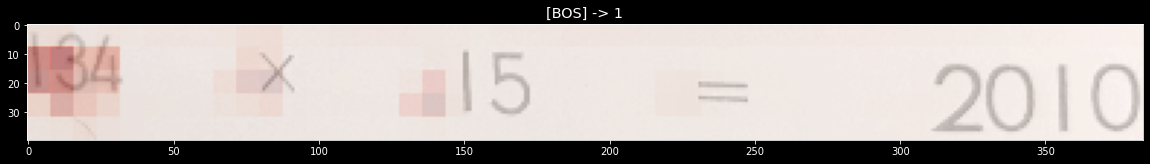

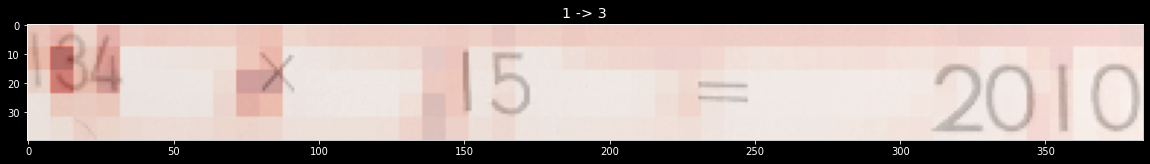

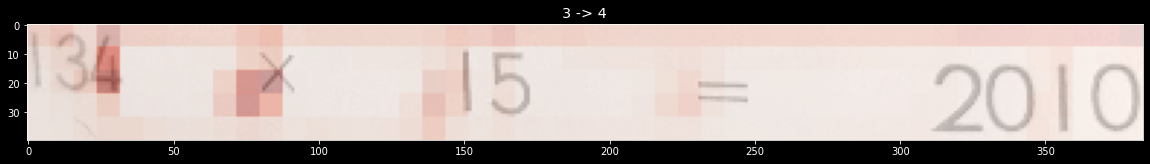

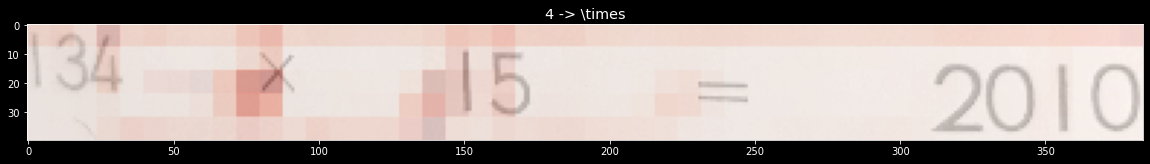

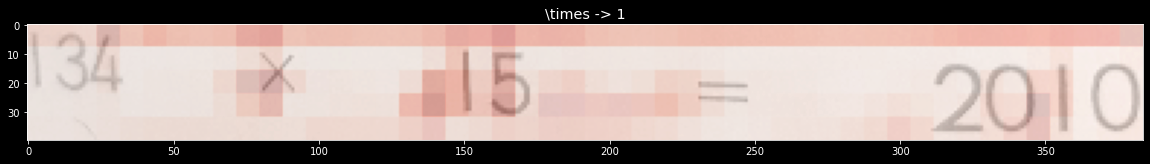

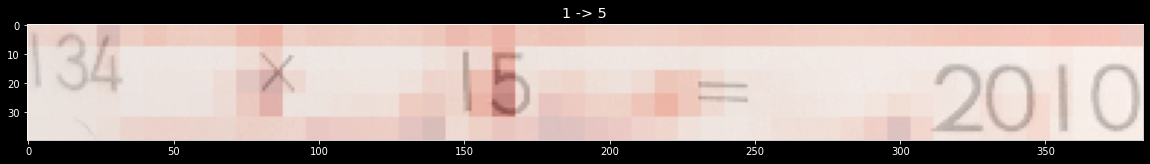

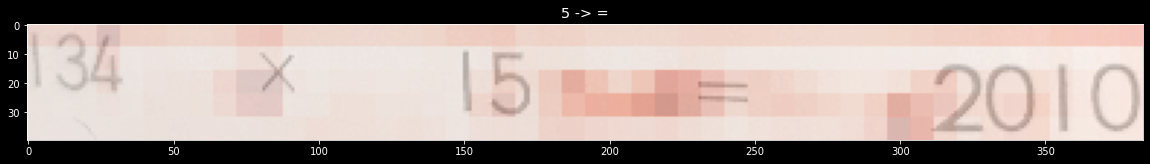

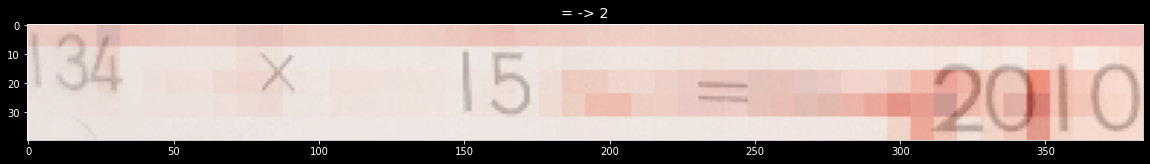

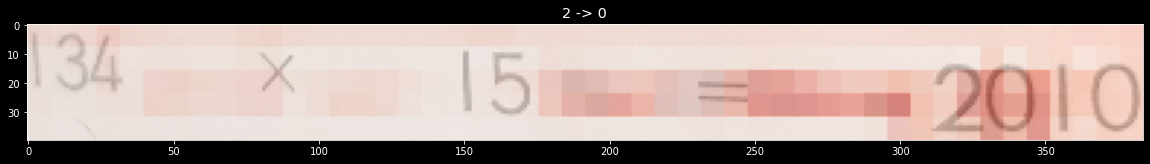

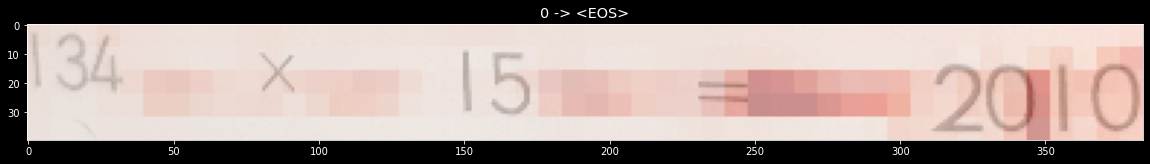

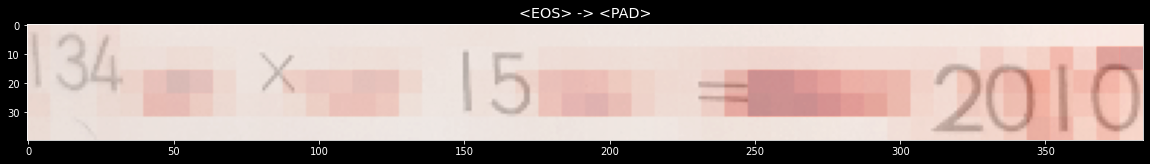

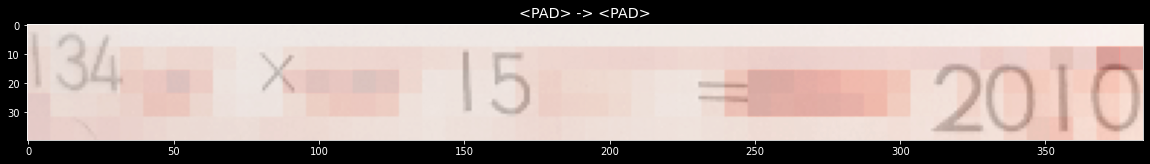

In [36]:
# ff = fa2[0][0].reshape(th, tw)


latex = ['[BOS]'] + sequence[0].split()
for idx in range(len(latex)-1):
    st = idx

    fig = plt.figure(figsize=(20, 10))
    plt.imshow(data_loader.dataset[0]['image'].squeeze(0), cmap='gray')
    j = 3 * st + 2
    for i in range(8):
        ff = fa2[j][i].reshape(th, tw)
        rf = ff.repeat(8, 0).repeat(8, 1)
        plt.imshow(rf, alpha=0.15, cmap='Reds')

    if idx + 1 < len(latex):
        next_c = latex[idx + 1]
    else:
        next_c = 'FIN'

    plt.title(f'{latex[idx]} -> {next_c}', size='x-large')
    plt.show()
    print()



In [ ]:
latex =  sequence[0].split()
i = 4
fig = plt.figure(figsize=(20, 10))
plt.imshow(data_loader.dataset[0]['image'].squeeze(0), cmap='gray')

for j in range(len(latex)):
    ff = fa2[3*j+2][i].reshape(th, tw)
    rf = ff.repeat(8, 0).repeat(8, 1)

    plt.imshow(rf, alpha=0.6, cmap='Reds')
plt.show()
print()



In [220]:
j

20

In [64]:
len(latex)

13

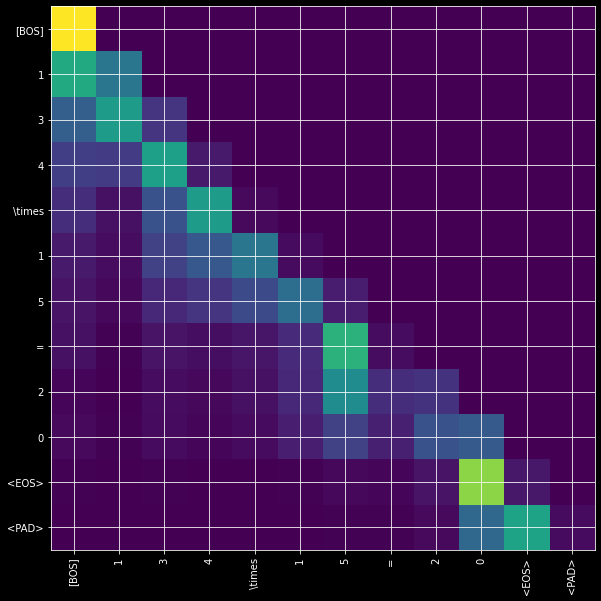

In [76]:
max_len = len(fa1) // 3

mat = np.zeros((max_len, max_len))
for i in range(max_len):
    idx = 3 * i + 2
    mat[i, :i+1]+= fa1[idx][0]

fig = plt.figure(figsize=(10, 10))
plt.imshow(mat)
plt.xticks(np.arange(max_len), latex[:-1], rotation='vertical')
plt.yticks(np.arange(max_len), latex[:-1])
plt.grid()
plt.show()

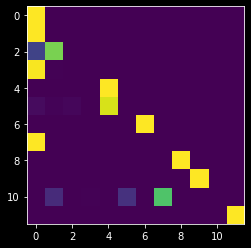

In [77]:
train_dataset.token_to_id[PAD]

2

In [80]:
a = next(iter(train_data_loader))

In [84]:
a['truth']['encoded']

tensor([[  0,  25, 229, 204,  10, 224,  14, 213, 137, 211, 204, 108,  25, 229,
         204,  10, 224, 125, 213, 137, 211, 204, 108,  59, 108,  25, 229, 204,
          10, 224, 169, 213, 214, 125, 137, 211, 204, 108,  59, 108,  25, 229,
         204,  10, 224,  61, 213, 214, 125, 137, 211, 204,   1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
        [  0, 204, 236, 224,  85, 213, 108, 111, 204, 236, 224, 177, 213, 108,
          85, 180, 229, 204, 236, 224,  85, 213, 108,  85, 204, 236, 224, 177,
         213, 108,  85, 137, 214, 204, 236, 224, 177, 213, 180, 229, 204, 236,
         224, 177, 213, 108, 177, 137, 236, 224, 177, 213, 214, 204, 236, 224,
         177, 213, 180, 229, 204, 236, 224, 177, 213, 108, 204, 108, 177, 137,
         229, 204, 236, 224, 177, 213, 214, 204, 108, 177, 137,   1],
        [  0, 177, 185,  10, 224,  61, 213, 180, 175, 177, 205, 108, 2